## Modelo de Múltipla Saída

Classificação dos 5 carácteres do Captcha





In [81]:
import numpy as np
import cv2
from six.moves import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow import keras
from keras.models import Sequential, Model                          #the model
from keras.layers import Dense, Dropout, Activation, Flatten, Input #fully connected layers
from keras.layers import Conv2D, MaxPooling2D                       #the convnet
from keras.utils import np_utils                                    #extra tools
from keras.layers.normalization import BatchNormalization
from keras.utils.layer_utils import count_params
from keras.callbacks import EarlyStopping

In [64]:
keras.__version__

'2.4.0'

In [65]:
# Carregando Imagens e Labels
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'

with open(data_dir+'CAPTCHAS_ALL'+'_Data' +'.pickle', 'rb') as f:
    data = pickle.load(f)

with open(data_dir+'CAPTCHAS_ALL'+'_Labels'+'.pickle', 'rb') as f:
    labels = pickle.load(f)

data.shape, labels.shape

((9725, 60, 200), (9725,))

In [66]:
letras_y = np.array([list(x) for x in labels])
np.unique(letras_y,return_counts=True)

(array(['0', '4', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
        'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
        'W', 'X', 'Y', 'Z'], dtype='<U1'),
 array([   1,    3,    1,    4, 1970, 1948, 1899, 1913, 1951, 1834, 1950,
        1894, 1301, 1754, 1900, 1811, 1918, 1874, 1780, 1817, 1952, 1919,
        1938, 1834, 1929, 2010, 1868, 1992, 1785, 1875]))

In [67]:
filtro = np.char.isnumeric(letras_y).sum(1)==0  # Filtro de Caracteres numericos
data = data[filtro]
labels = labels[filtro]

letras_y = np.array([list(x) for x in labels])
np.unique(letras_y,return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype='<U1'),
 array([1969, 1946, 1898, 1913, 1949, 1834, 1948, 1893, 1300, 1751, 1898,
        1808, 1916, 1872, 1779, 1816, 1951, 1919, 1936, 1831, 1928, 2008,
        1867, 1992, 1784, 1874]))

In [68]:
lb = LabelBinarizer().fit(letras_y[:,1])
lab = []
for ltr in letras_y:
    t = lb.transform(ltr)
    lab.append(t)

In [69]:
labels_lb = np.stack(lab, axis=1)
labels_lb.shape

(5, 9716, 26)

In [70]:
(train_x, val_x, train_y, val_y) = train_test_split(data, lab, test_size=0.3, random_state=123)

In [71]:
train_y = np.stack(train_y, axis=1)
val_y = np.stack(val_y, axis=1)
train_y.shape, val_y.shape

((5, 6801, 26), (5, 2915, 26))

In [72]:
X_train = np.expand_dims(train_x, axis = 3)
X_valid = np.expand_dims(val_x, axis = 3)
X_train.shape, X_valid.shape

((6801, 60, 200, 1), (2915, 60, 200, 1))

In [73]:
v_y = []
for x in val_y:
    v_y.append(x)

t_y = []
for x in train_y:
    t_y.append(x)

---
## Modelo de Classificação Múltipla

In [74]:
img_rows = 60
img_cols = 200
img_channels = 1

x = Input((img_rows, img_cols, img_channels))

y = Conv2D(16, (5, 5))(x)
y = Activation('relu')(y)
y = MaxPooling2D((2,2))(y)
y = BatchNormalization()(y)

y = Conv2D(32, (5, 5))(y)
y = Activation('relu')(y)
y = MaxPooling2D((2,2))(y)
y = BatchNormalization()(y)

y = Conv2D(64, (3, 3))(y)
y = Activation('relu')(y)
y = MaxPooling2D((2,2))(y)
y = BatchNormalization()(y)

y = Flatten()(y)
y = Dense(512, activation="relu")(y)
y = Dropout(0.6)(y)
y = Dense(512, activation="relu")(y)
y = Dropout(0.3)(y)

digit_1 = Dense(26, activation='softmax', name = 'c1')(y)
digit_2 = Dense(26, activation='softmax', name = 'c2')(y)
digit_3 = Dense(26, activation='softmax', name = 'c3')(y)
digit_4 = Dense(26, activation='softmax', name = 'c4')(y)
digit_5 = Dense(26, activation='softmax', name = 'c5')(y)
branches = [digit_1,digit_2,digit_3,digit_4,digit_5]
model = Model(inputs=x, outputs=branches,  name = 'Modelo_Captha')

In [75]:
model.summary()

Model: "Modelo_Captha"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 56, 196, 16)  416         input_4[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 56, 196, 16)  0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 28, 98, 16)   0           activation_9[0][0]               
______________________________________________________________________________________

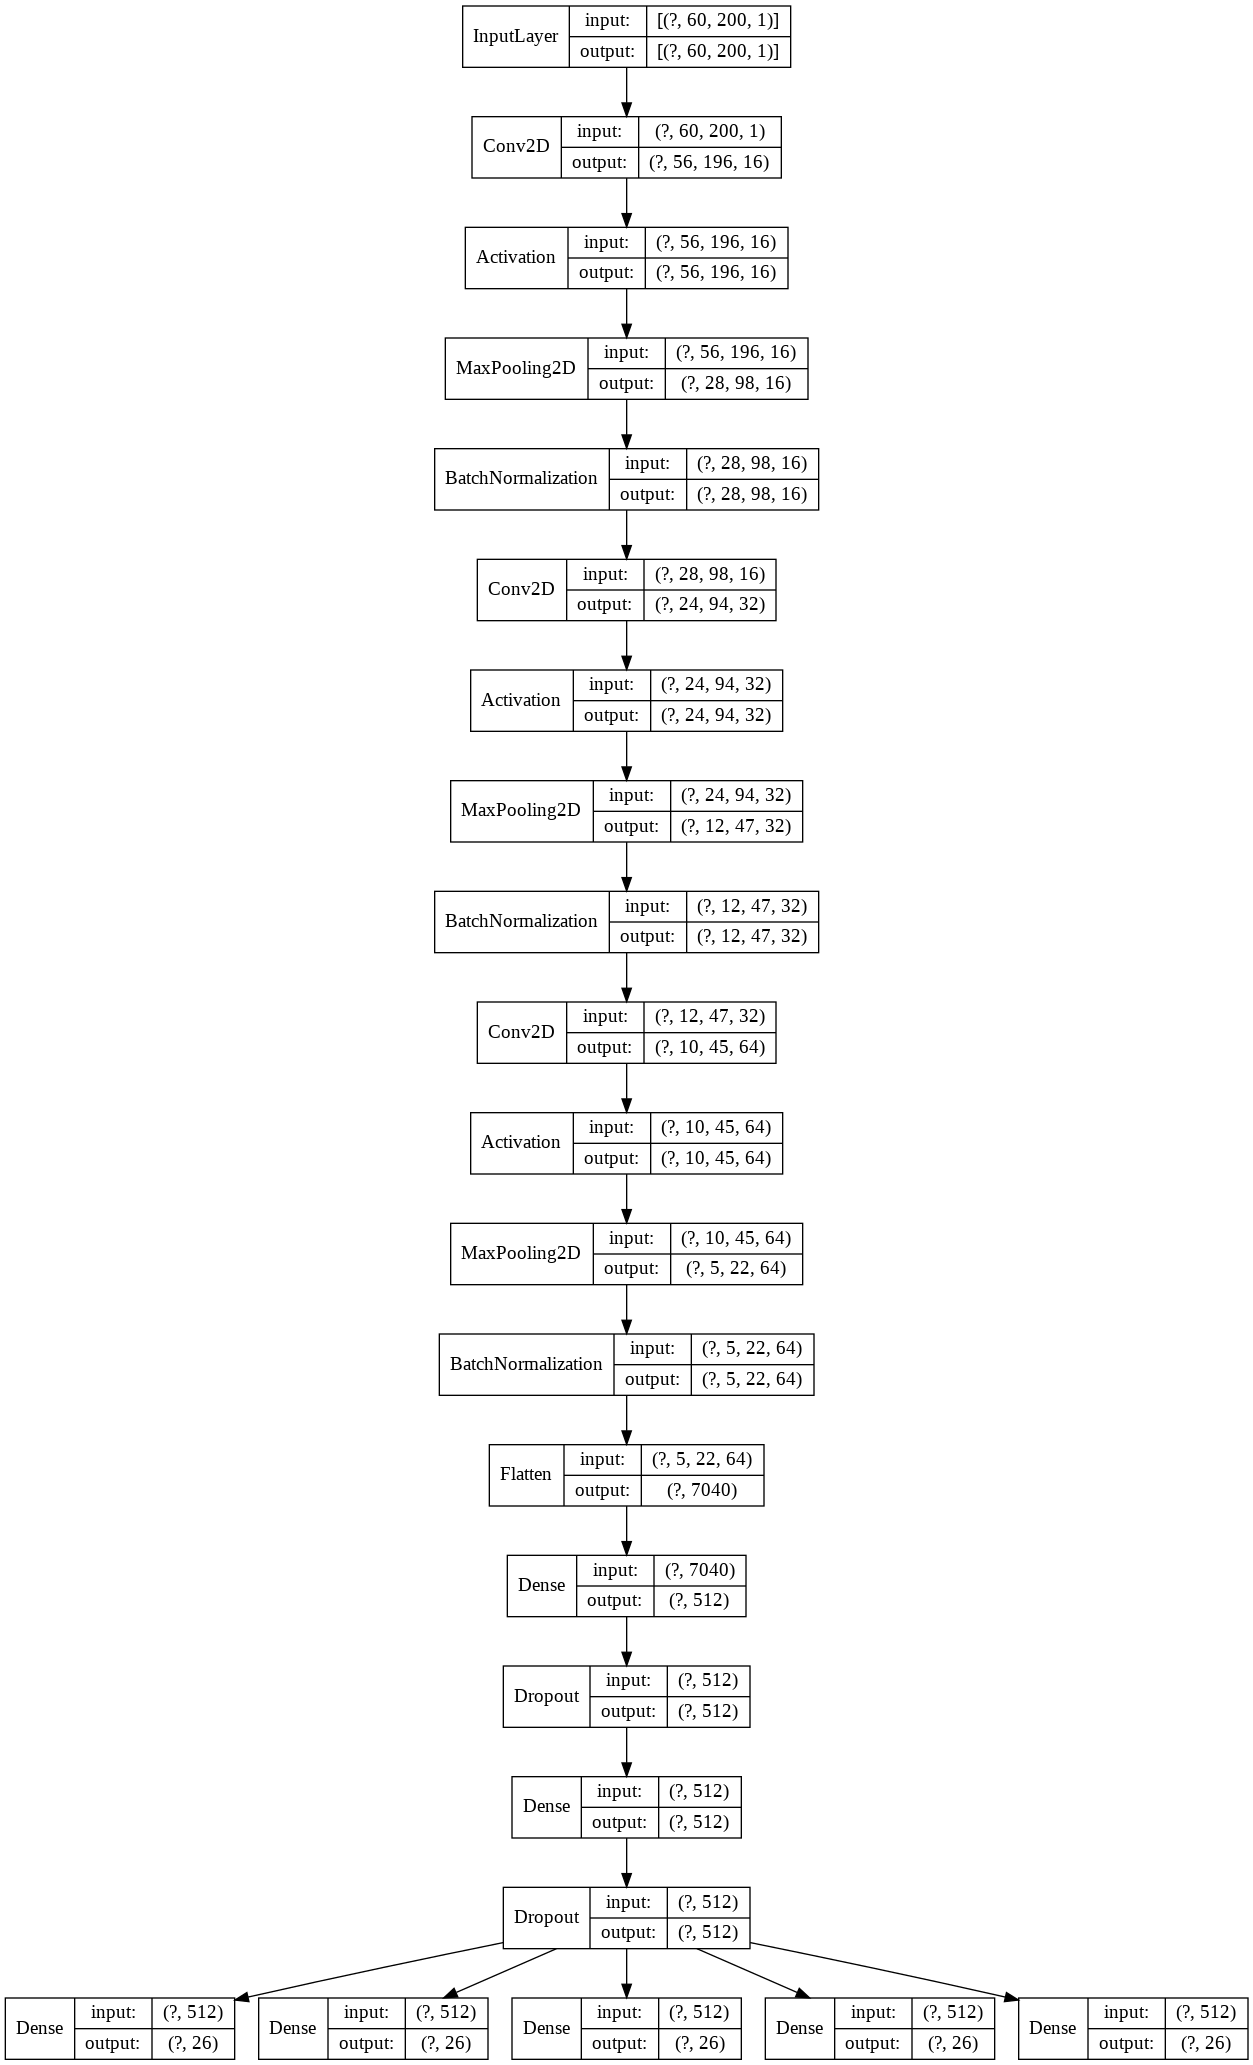

In [76]:
keras.utils.plot_model(model, "shape_info.png", show_shapes=True, show_layer_names=False)

In [77]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [78]:
estop = EarlyStopping(patience=50, mode='min', min_delta=0.001, monitor='val_loss')

history = model.fit(X_train, t_y,
                    validation_data=(X_valid, v_y), 
                    batch_size=100, epochs=500, verbose=1, 
                    callbacks=[estop])

Epoch 1/500
69/69 [==============================] - 3s 38ms/step - loss: 16.6020 - c1_loss: 3.3207 - c2_loss: 3.3238 - c3_loss: 3.3186 - c4_loss: 3.3254 - c5_loss: 3.3135 - c1_accuracy: 0.0390 - c2_accuracy: 0.0432 - c3_accuracy: 0.0396 - c4_accuracy: 0.0401 - c5_accuracy: 0.0469 - val_loss: 16.2838 - val_c1_loss: 3.2566 - val_c2_loss: 3.2562 - val_c3_loss: 3.2561 - val_c4_loss: 3.2572 - val_c5_loss: 3.2576 - val_c1_accuracy: 0.0456 - val_c2_accuracy: 0.0401 - val_c3_accuracy: 0.0408 - val_c4_accuracy: 0.0377 - val_c5_accuracy: 0.0436
Epoch 2/500
69/69 [==============================] - 2s 30ms/step - loss: 16.2800 - c1_loss: 3.2541 - c2_loss: 3.2554 - c3_loss: 3.2567 - c4_loss: 3.2579 - c5_loss: 3.2560 - c1_accuracy: 0.0463 - c2_accuracy: 0.0438 - c3_accuracy: 0.0437 - c4_accuracy: 0.0423 - c5_accuracy: 0.0447 - val_loss: 16.2795 - val_c1_loss: 3.2527 - val_c2_loss: 3.2548 - val_c3_loss: 3.2561 - val_c4_loss: 3.2576 - val_c5_loss: 3.2583 - val_c1_accuracy: 0.0532 - val_c2_accuracy: 0

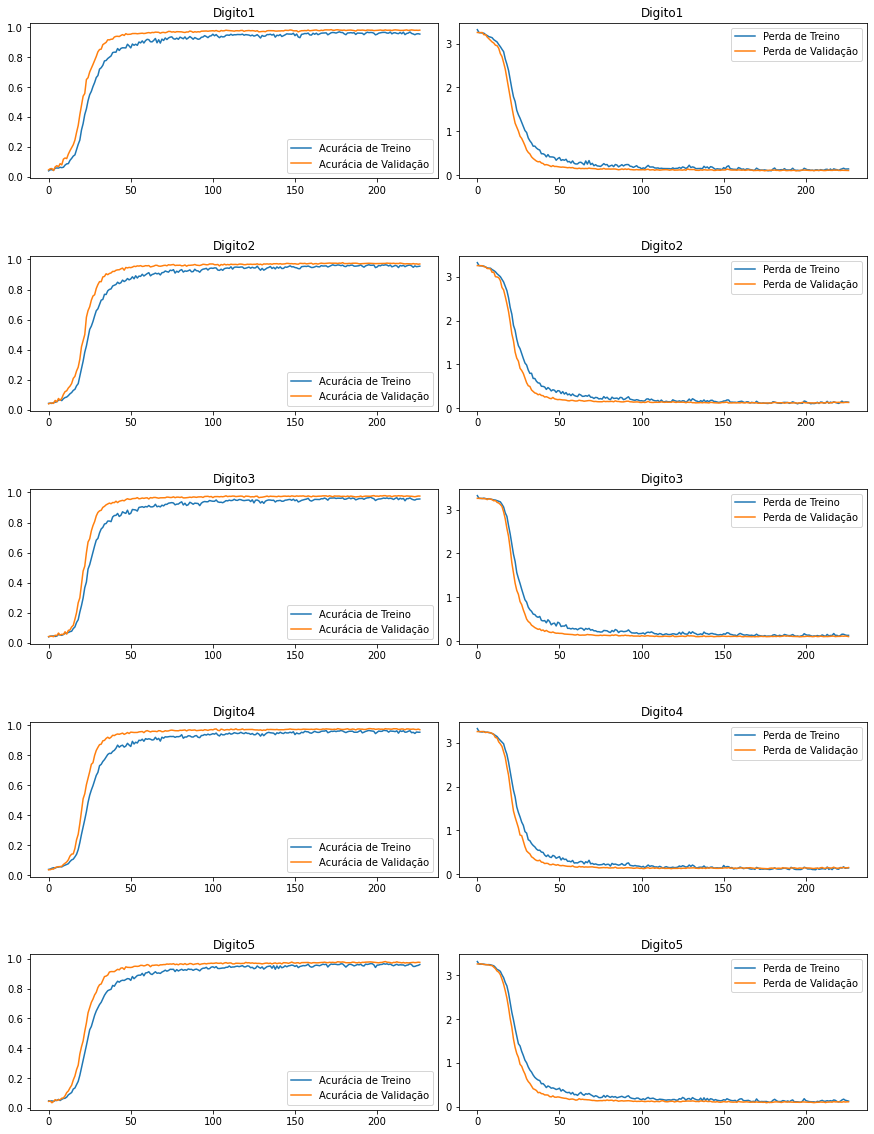

In [82]:
fig, axs = plt.subplots(5, 2, figsize=(15,20))
fig.subplots_adjust(hspace=0.5, wspace=0.05)

for i in range(1,6):
    nacc  = 'c' + str(i) + '_accuracy' 
    nvacc = 'val_c' + str(i) + '_accuracy'
    nlos  = 'c' + str(i) + '_loss'
    nvlos = 'val_c' + str(i) + '_loss'

    axs[i-1,0].plot(history.history[nacc], label='Acurácia de Treino')
    axs[i-1,0].plot(history.history[nvacc], label = 'Acurácia de Validação')
    axs[i-1,0].set_title('Digito'+str(i))
    axs[i-1,0].legend(loc='lower right')

    axs[i-1,1].plot(history.history[nlos], label='Perda de Treino')
    axs[i-1,1].plot(history.history[nvlos], label = 'Perda de Validação')
    axs[i-1,1].set_title('Digito'+str(i))
    axs[i-1,1].legend(loc='upper right')


In [93]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(data_dir+'LabelBinarizer' +'.pickle', 'wb') as f:
    pickle.dump(lb, f, pickle.HIGHEST_PROTOCOL)

with open(data_dir+'Best_ModelCaptcha' +'.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [90]:
# salva os dados para uso posterior
model_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/Model/assets


## Classificação nos Novos Captchas

In [91]:
# salva os dados para uso posterior
data_dir = '/content/drive/My Drive/Colab Notebooks/Data_Colab/Captcha_Break/'

with open(data_dir+'SDBCclean'+'_Data' +'.pickle', 'rb') as f:
    data = pickle.load(f)

with open(data_dir+'SDBCclean'+'_Labels'+'.pickle', 'rb') as f:
    labels = pickle.load(f)

data.shape, labels.shape

((547, 60, 200), (547,))

In [94]:
letras_y = np.array([list(x) for x in labels])
np.unique(letras_y,return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype='<U1'),
 array([101, 103, 103, 112, 110,  97, 100, 122,  99, 105, 107, 121, 104,
        114, 113,  91, 100, 108, 102,  95, 109, 104, 104, 101, 109, 101]))

In [102]:
lab = []
for ltr in letras_y:
    t = lb.transform(ltr)
    lab.append(t)
    
labels_lb = np.stack(lab, axis=1)
v_y = []
for x in labels_lb:
    v_y.append(x)


x_data = np.expand_dims(data, axis = 3)
x_data.shape

(547, 60, 200, 1)

In [ ]:
model.evaluate(x_data, v_y)

In [127]:
label_pred = []
labels_prob = []

predict = model.predict(x_data, batch_size=1)

for img in predict:
    pred = img.max(1)
    cls_pred = lb.inverse_transform(img)
    label_pred.append(cls_pred)
    labels_prob.append(pred)

In [134]:
captcha_pred = np.stack(label_pred, axis=1)
captcha_pred = np.array([x1+x2+x3+x4+x5 for x1,x2,x3,x4,x5 in captcha_pred])

In [137]:
# val_erro = lb.inverse_transform(predict) != lb.inverse_transform(labels_lb)
val_erro = labels != captcha_pred
print('Quantidade total de erros: ', sum(val_erro))
print('Quantidade total de dados: ', len(val_erro))
print('Percentual de erros: {:.2%}'.format(sum(val_erro)/len(val_erro)) )

Quantidade total de erros:  31
Quantidade total de dados:  547
Percentual de erros: 5.67%


In [ ]:
captcha_pred = np.array([x1+x2+x3+x4+x5 for x1,x2,x3,x4,x5 in cls_pred])

#### Alguns dos Erros

Label Verdadeiro:LEQOF
Label Predito:   IEQOF


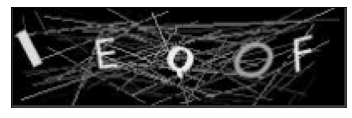

In [142]:
j = 0
i = np.array(np.where(val_erro))[0,j]

print('Label Verdadeiro:' + labels[i] + '\n' + 'Label Predito:   ' + captcha_pred[i])

plt.imshow(data[i], cmap='binary')
plt.xticks([]), plt.yticks([])
plt.show()

Label Verdadeiro:DWDJS
Label Predito:   DWDLS


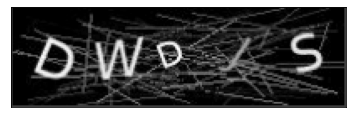

In [143]:
j = 5
i = np.array(np.where(val_erro))[0,j]

print('Label Verdadeiro:' + labels[i] + '\n' + 'Label Predito:   ' + captcha_pred[i])

plt.imshow(data[i], cmap='binary')
plt.xticks([]), plt.yticks([])
plt.show()

Label Verdadeiro:QEXKK
Label Predito:   GEXKK


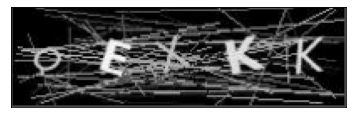

In [144]:
j = 30
i = np.array(np.where(val_erro))[0,j]

print('Label Verdadeiro:' + labels[i] + '\n' + 'Label Predito:   ' + captcha_pred[i])
plt.imshow(data[i], cmap='binary')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
from sklearn import metrics

print(metrics.confusion_matrix(y_true, y_pred))

In [ ]:
model.evaluate(x_data, v_y)

In [ ]:
j = 30
i = np.array(np.where(val_erro))[0,j]
labels[val_erro]

print('Label Verdadeiro:' + labels[i] + '\n' + 'Label Predito:   ' + captcha_pred[i])
plt.imshow(data[i], cmap='binary')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
label_pred = []
labels_prob = []

predict = model.predict(x_data, batch_size=1)

for img in predict:
    pred = img.max(1)
    cls_pred = lb.inverse_transform(img)
    label_pred.append(cls_pred)
    labels_prob.append(pred)

### Tabelas de Confusão de Classificações Corretas e Erradas

In [ ]:
import pandas as pd
import string  
import seaborn as sn

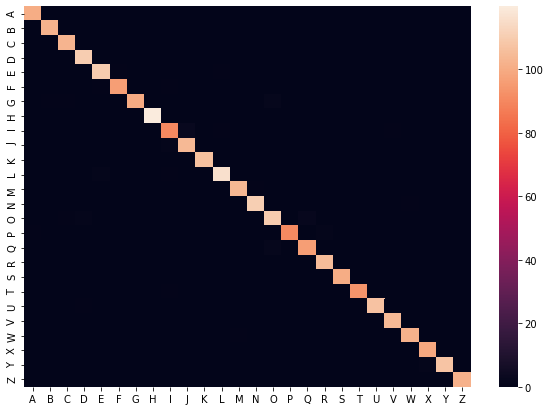

In [218]:
pred_cer = np.stack(predict, axis=1)
pred_cer = pred_cer.reshape((2735,26))
prev = np.stack([list(x) for x in captcha_pred], axis=0).flatten()

soma = []
for i in string.ascii_uppercase:
    letr = (pred_cer[prev == i]).sum(0)
    soma.append(letr)
soma = np.array(soma)


df = pd.DataFrame(np.round(soma, 2), 
                  index = [i for i in string.ascii_uppercase],
                  columns = [i for i in string.ascii_uppercase])
plt.figure(figsize = (10,7))
sn.heatmap(df)

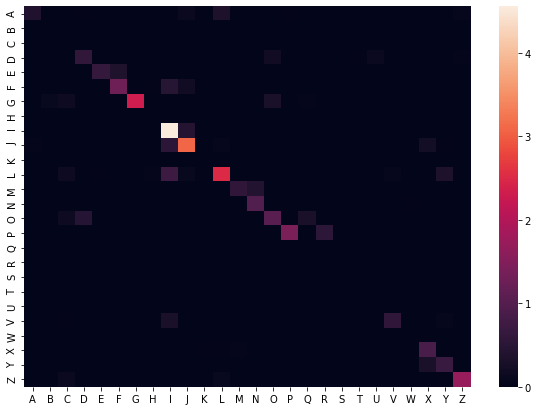

In [239]:
pred_err = np.stack(predict, axis=1)[val_erro]
pred_err = pred_err.reshape((155,26))
prev = np.stack([list(x) for x in captcha_pred[val_erro]], axis=0).flatten()
labs = np.stack([list(x) for x in labels[val_erro]], axis=0).flatten()

val_err_ltr = prev != labs

pred_err = pred_err[val_err_ltr]
prev = prev[val_err_ltr]

soma = []
for i in string.ascii_uppercase:
    letr = (pred_err[prev == i]).sum(0)
    soma.append(letr)
soma = np.array(soma)

df = pd.DataFrame(np.round(soma, 2), 
                  index = [i for i in string.ascii_uppercase],
                  columns = [i for i in string.ascii_uppercase])
plt.figure(figsize = (10,7))
sn.heatmap(df)